# Mount drive

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Load data

In [ ]:
RAW_DATASET_1_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/external/PROMISE-reclass.csv'
RAW_DATASET_2_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/external/PROMISE-exp.csv'

df_1 = pd.read_csv(RAW_DATASET_1_PATH)
df_2 = pd.read_csv(RAW_DATASET_2_PATH)
df = pd.concat([df_1, df_2], ignore_index=True)

# Drop unused columns and rows

In [6]:
X_column = 'RequirementText'
y_column = 'Class'

df[y_column].value_counts()

SE    126
US     85
O      77
PE     66
Name: Class, dtype: int64

In this research study we focus on:
*   **SE**: security requirements;
*   **US**: usability requirements;
*   **O**: operational requirements;
*   **PE**: performance requirements.

In [1]:
to_drop_columns = ['ProjectID', 'IsFunctional', 'IsQuality']
df = df.drop(to_drop_columns, axis=1)

to_drop_classes = {'LF', 'SC', 'A', 'MN', 'L', 'FT', 'PO', 'F'}
mask = ~df[y_column].isin(to_drop_classes)
df = df[mask]

df.to_csv('/content/drive/MyDrive/Tesi/Master-Thesis/data/interim/promise-reclass.csv', index=False)

NameError: ignored

# Load filtered data


In [4]:
FILTERED_DATASET_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/interim/promise-reclass_filtered.csv'
df = pd.read_csv(FILTERED_DATASET_PATH)

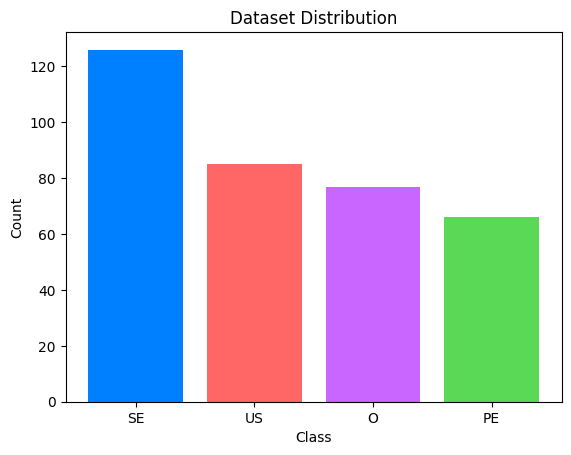

In [8]:
# Dataset distribution
class_counts = df[y_column].value_counts()
class_labels = ['SE', 'US', 'O', 'PE']
colors = ['#007FFF', '#FF6666', '#C966FF', '#59D955']

# Plotting histogram
plt.bar(class_labels, class_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Dataset Distribution')
plt.savefig("/content/drive/MyDrive/Tesi/Master-Thesis/figures/dataset_preprocess/distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Infrequent words

In [ ]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

all_words = [word.lower() for tokens in df['RequirementText'].apply(lambda x: word_tokenize(x)) for word in tokens]
freq_dist = FreqDist(all_words)
one_occ_words = [word for word, freq in freq_dist.items() if freq <= 2]
sentence_lengths = df['RequirementText'].apply(lambda x: len(word_tokenize(x)))
mean_sentence_length = np.mean(sentence_lengths)

print(f"Number of words appearing once: {len(one_occ_words)}")
print(f"Mean size of sentences in the dataset: {mean_sentence_length}")

Number of words appearing once: 322
Mean size of sentences in the dataset: 7.27683615819209


# Text normalization

In [ ]:
def normalize_text_quantum(text):
    return text.translate(str.maketrans("", "", string.punctuation)).lower()

def normalize_text_classical(text):
    text = text.translate(str.maketrans("", "", string.punctuation)).lower()
    tokens = word_tokenize(text)

    # stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    tokens = [token for token in tokens if not (token.isdigit() or len(token) <= 2)]
    return " ".join(tokens)

df_normalized_quantum = df.copy()
df_normalized_classical = df.copy()

df_normalized_quantum[X_column] = df_normalized_quantum[X_column].apply(normalize_text_quantum)
df_normalized_classical[X_column] = df_normalized_classical[X_column].apply(normalize_text_classical)

df_normalized_quantum.to_csv('/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv', index=False)
df_normalized_classical.to_csv('/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv', index=False)

# [TESTING] Data balancing

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

def binary_balance(df, target_column):
    class_elements = df[df[y_column] == target_column]
    other_class_elements = df[df[y_column] != target_column]
    sampled_data = other_class_elements.sample(n=len(class_elements), random_state=SEED)
    return pd.concat([class_elements, sampled_data], ignore_index=True)

def multi_balance(df):
    X_arr = df[X_column].to_numpy()
    y_arr = df[y_column].to_numpy()
    rus = RandomUnderSampler(random_state=SEED)
    X_resampled, y_resampled = rus.fit_resample(X_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
    return pd.DataFrame({X_column: X_resampled.flatten(), y_column: y_resampled.flatten()})

df_se_quantum = binary_balance(df_normalized_quantum, 'SE')
df_us_quantum = binary_balance(df_normalized_quantum, 'US')
df_o_quantum = binary_balance(df_normalized_quantum, 'O')
df_pe_quantum = binary_balance(df_normalized_quantum, 'PE')

df_se_classical = binary_balance(df_normalized_classical, 'SE')
df_us_classical = binary_balance(df_normalized_classical, 'US')
df_o_classical = binary_balance(df_normalized_classical, 'O')
df_pe_classical = binary_balance(df_normalized_classical, 'PE')

df_multi_quantum = multi_balance(df_normalized_quantum)
df_multi_classical = multi_balance(df_normalized_classical)

In [ ]:
# custom_primary = '#007FFF'
# custom_secondary = '#FF6666'

# class_counts = df[y_column].value_counts()
# new_class_counts = df_multi_quantum[y_column].value_counts()

# fig, axs = plt.subplots(1, 2, figsize=(6, 3))
# axs[0].bar(class_counts.index, class_counts, color=custom_primary)
# axs[0].set_ylabel('Occurrences')
# axs[0].set_title('Before Undersampling')
# axs[0].set_xlabel('Class')

# axs[1].bar(new_class_counts.index, new_class_counts.values, color=custom_secondary)
# axs[1].set_title('After Undersampling')
# axs[1].set_xlabel('Class')

# plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/Tesi/Master-Thesis/figures/dataset_preprocess/undersampling.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
BALANCED_DATA_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/balanced/'

df_se_quantum.to_csv(BALANCED_DATA_PATH + 'quantum_SE.csv', index=False)
df_us_quantum.to_csv(BALANCED_DATA_PATH + 'quantum_US.csv', index=False)
df_o_quantum.to_csv(BALANCED_DATA_PATH + 'quantum_O.csv', index=False)
df_pe_quantum.to_csv(BALANCED_DATA_PATH + 'quantum_PE.csv', index=False)


df_se_classical.to_csv(BALANCED_DATA_PATH + 'classical_SE.csv', index=False)
df_us_classical.to_csv(BALANCED_DATA_PATH + 'classica_US.csv', index=False)
df_o_classical.to_csv(BALANCED_DATA_PATH + 'classical_O.csv', index=False)
df_pe_classical.to_csv(BALANCED_DATA_PATH + 'classical_PE.csv', index=False)

df_multi_quantum.to_csv(BALANCED_DATA_PATH + 'quantum.csv', index=False)
df_multi_classical.to_csv(BALANCED_DATA_PATH + 'classical.csv', index=False)